In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [3]:
# filename="../results_relu.xlsx"
filename="../results_relu_width_same.xlsx"
init_regret_filename="../initial-regret.xlsx"

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

In [4]:
keep_ratio = 0.98

data = pd.read_excel(filename)
if data.duplicated().any():
    print("Contains duplicates!")
    print(data.duplicated().sum())
    print(data[data.duplicated()])
else:
    print("No Duplicates!")
groupby_cols = [
    'd', 'M', 'T', 'act', 'noise', 'hidden-layers',
    'patience', 'patience-tol', 'epochs', 
    'lr', 'reduce-lr', 'trials',
]
data = data[
    data.groupby(groupby_cols)['regret'].transform(
        lambda x : x <= x.quantile(keep_ratio)
    )
]
data = data.groupby(groupby_cols).agg(
    regret_mean=pd.NamedAgg(column="regret", aggfunc="mean"),
    regret_median=pd.NamedAgg(column="regret", aggfunc="median"),
    regret_std=pd.NamedAgg(column="regret", aggfunc="std"),
    count=pd.NamedAgg(column="regret", aggfunc="count"),
    num_accesses_mean=pd.NamedAgg(column="num_accesses", aggfunc="mean"),
    num_accesses_std=pd.NamedAgg(column="num_accesses", aggfunc="std"),
).reset_index()
data["regret_std"] /= np.sqrt(data["count"])
data["num_accesses_std"] /= np.sqrt(data["count"])
data_init_regret = pd.read_excel(init_regret_filename)
data = data.merge(
    data_init_regret[['d', 'M', 'noise', 'act', 'initial-regret']], 
    on = ['d', 'M', 'noise', 'act'],
    how = 'left',
)
data["epsilon"] = data["regret_mean"] / data["initial-regret"]
data["epsilon_std"] = data["regret_std"] / data["initial-regret"]
data = data.sort_values(by=['noise', 'd', 'M', 'T', 'hidden-layers'], ascending=True)
data.to_excel(f"../analysis_relu_width_same_{keep_ratio}.xlsx")
# data.to_excel(f"../analysis_relu{keep_ratio}.xlsx")
data

In [20]:
# data_new = data[data['hidden-layers'] == 1]
data_new = data.loc[
    data.groupby(['d', 'M', 'T', 'noise'])['regret_mean'].idxmin()
].reset_index().set_index('T')
# data_new

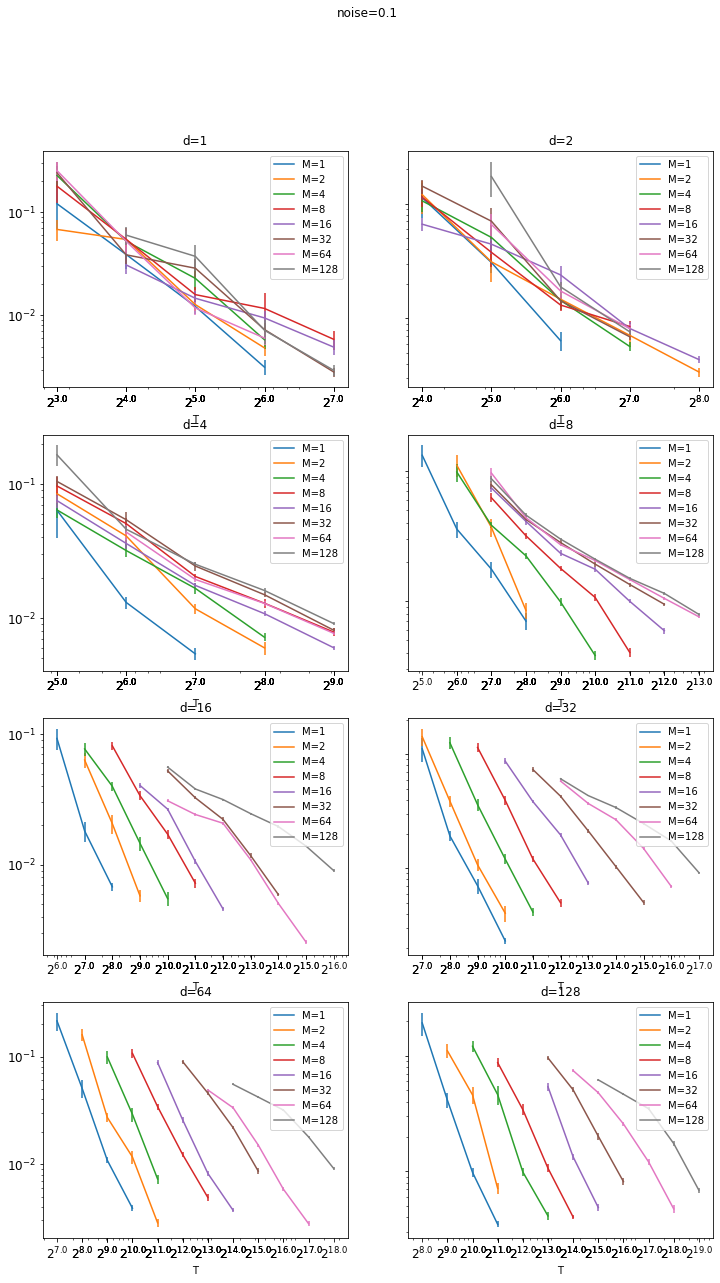

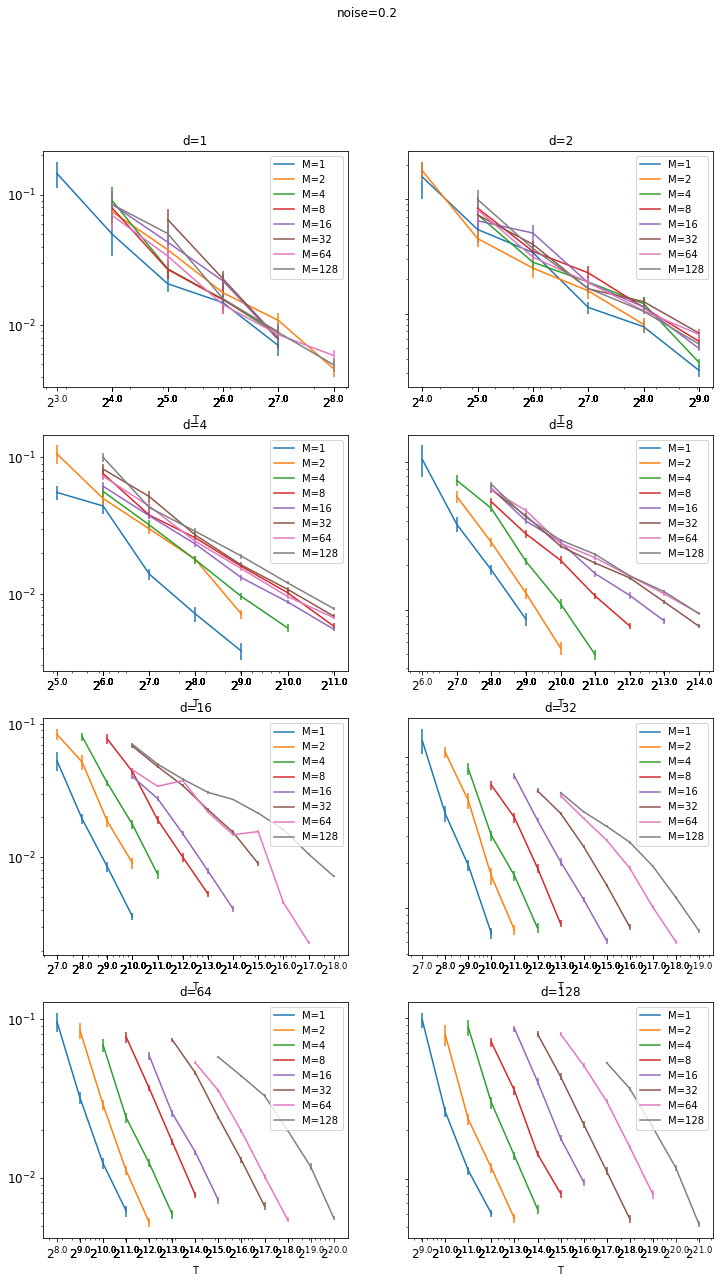

In [47]:
def to_exp_str(l):
    return [f"$2^{{{np.log2(x)}}}$" for x in l]

grouped_noise = data_new.groupby(['noise'])
for noise in grouped_noise.groups.keys():
    grouped_d = grouped_noise.get_group(noise).groupby(['d'])
    ncols = 2
    nrows = (len(grouped_d.groups) + ncols - 1) // ncols 
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*5))
    fig.suptitle(f"noise={noise}")
    for d, ax1 in zip(grouped_d.groups.keys(), axes.flatten()):
        grouped_d_M = grouped_d.get_group(d).groupby([
            'M'
        ])
        for key in grouped_d_M.groups.keys():
            grouped_d_M.get_group(key).plot(
                legend=True,
                logx=True,
                logy=True,
                ax=ax1,
                y='epsilon',
                yerr='epsilon_std',
                label=f'M={key}',
                sharey=True,
            )
        ax1.set_xticks(grouped_d.get_group(d).index.tolist())
        ax1.set_xticklabels(to_exp_str(
            grouped_d.get_group(d).index.tolist()
        ))
        # ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax1.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax1.set_title(f"d={d}")
    plt.show()

In [48]:
def get_T_e_max(data, epsilon):
    return data.where(data['epsilon'] < epsilon).groupby(['d', 'M', 'noise']).agg(
        T_e_max = pd.NamedAgg(column="T", aggfunc="min"),
    ).reset_index()
def get_T_e_min(data, epsilon):
    return data.where(data['epsilon'] > epsilon).groupby(['d', 'M', 'noise']).agg(
        T_e_min = pd.NamedAgg(column="T", aggfunc="max"),
    ).reset_index()

In [49]:
def analyze_data(data, epsilon):
    temp = get_T_e_max(data, epsilon).merge(
        get_T_e_min(data, epsilon),
        on=['d', 'M', 'noise'],
        how='outer',
    )
    temp = temp.merge(
        data[[
            "d", "M", "noise", "T",
            "num_accesses_mean", "num_accesses_std",
        ]].rename(columns={
                "num_accesses_mean": "S_max",
                "num_accesses_std": "S_max_std",
                "T": "T_e_max",
        }),
        on=['d', 'M', 'noise', "T_e_max"],
        how='left',
    )
    temp = temp.merge(
        data[[
            "d", "M", "noise", "T",
            "num_accesses_mean", "num_accesses_std",
        ]].rename(columns={
                "num_accesses_mean": "S_min",
                "num_accesses_std": "S_min_std",
                "T": "T_e_min",
        }),
        on=['d', 'M', 'noise', "T_e_min"],
        how='left',
    )
    
    fig1, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
    axes = axes.reshape(-1)

    def format_ax(ax):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    
    # M vs T for different d
    ax_cur = axes[0]
    grouped = temp.groupby("d")
    for d in grouped.groups.keys():
        cur_data = grouped.get_group(d)
        ax_cur.errorbar(
            x=cur_data['M'],
            y=(cur_data['T_e_max'] + cur_data['T_e_min'])/2,
            yerr=(cur_data['T_e_min'] - cur_data['T_e_max'])/2,
        )
    format_ax(ax_cur)
    ax_cur.set_xticks(data["M"].tolist())
    ax_cur.set_xticklabels(to_exp_str(data["M"].tolist()))
    ax_cur.set_yticks(data["T"].tolist())
    ax_cur.set_yticklabels(to_exp_str(data["T"].tolist()))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('M')
    ax_cur.set_ylabel('$T_\epsilon$')
    ax_cur.legend([f"d={d}" for d in grouped.groups.keys()])
    ax_cur.set_title(f"$M$ vs $T_\epsilon$ for different $d$")

    # d vs T for different M
    ax_cur = axes[1]
    grouped = temp.groupby("M")
    for d in grouped.groups.keys():
        cur_data = grouped.get_group(d)
        ax_cur.errorbar(
            x=cur_data['d'],
            y=(cur_data['T_e_max'] + cur_data['T_e_min'])/2,
            yerr=(cur_data['T_e_min'] - cur_data['T_e_max'])/2,
        )
    format_ax(ax_cur)
    ax_cur.set_xticks(data["d"].tolist())
    ax_cur.set_xticklabels(to_exp_str(data["d"].tolist()))
    ax_cur.set_yticks(data["T"].tolist())
    ax_cur.set_yticklabels(to_exp_str(data["T"].tolist()))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('d')
    ax_cur.set_ylabel('$T_\epsilon$')
    ax_cur.legend([f"M={m}" for m in grouped.groups.keys()])
    ax_cur.set_title(f"$d$ vs $T_\epsilon$ for different $M$")

    # d*M vs T
    ax_cur = axes[2]
    ax_cur.scatter(
        temp["d"] * temp["M"], 
        temp["T_e_min"],
        alpha=0.3,
    )
    ax_cur.scatter(
        temp["d"] * temp["M"], 
        temp["T_e_max"],
        alpha=0.3,
    )
    format_ax(ax_cur)
    dM = (data["d"] * data["M"]).tolist()
    ax_cur.set_xticks(dM)
    ax_cur.set_xticklabels(to_exp_str(dM))
    ax_cur.set_yticks(data["T"].tolist())
    ax_cur.set_yticklabels(to_exp_str((data["T"]).tolist()))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('$M\\times d$')
    ax_cur.set_ylabel('$T_\epsilon$')
    ax_cur.legend(["min", "max"])
    ax_cur.set_title(f"$M\\times d$ vs $T_\epsilon$")

    # d*M vs S
    ax_cur = axes[3]
    ax_cur.scatter(
        temp["d"] * temp["M"], 
        temp["S_min"],
        alpha=0.3,
    )
    ax_cur.scatter(
        temp["d"] * temp["M"], 
        temp["S_max"],
        alpha=0.3,
    )
    format_ax(ax_cur)
    dM = (data["d"] * data["M"]).tolist()
    ax_cur.set_xticks(dM)
    ax_cur.set_xticklabels(to_exp_str(dM))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('$M\\times d$')
    ax_cur.set_ylabel('$S$')
    ax_cur.legend(["min", "max"])
    ax_cur.set_title(f"$M\\times d$ vs $S$")

    # M vs S for different d
    ax_cur = axes[4]
    grouped = temp.groupby("d")
    for d in grouped.groups.keys():
        cur_data = grouped.get_group(d)
        ax_cur.errorbar(
            x=cur_data['M'],
            y=(cur_data['S_max'] + cur_data['S_min']) / 2,
            yerr=(cur_data['S_max'] - cur_data['S_min']) / 2,
        )
    format_ax(ax_cur)
    ax_cur.set_xticks(data["M"].tolist())
    ax_cur.set_xticklabels(to_exp_str(data["M"].tolist()))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('M')
    ax_cur.set_ylabel('$S$')
    ax_cur.legend([f"d={d}" for d in grouped.groups.keys()])
    ax_cur.set_title(f"$M$ vs $S$ for different $d$")

    # d vs S for different M
    ax_cur = axes[5]
    grouped = temp.groupby("M")
    for d in grouped.groups.keys():
        cur_data = grouped.get_group(d)
        ax_cur.errorbar(
            x=cur_data['d'],
            y=(cur_data['S_max'] + cur_data['S_min'])/2,
            yerr=(cur_data['S_min'] - cur_data['S_max'])/2,
        )
    format_ax(ax_cur)
    ax_cur.set_xticks(data["d"].tolist())
    ax_cur.set_xticklabels(to_exp_str(data["d"].tolist()))
    ax_cur.axis('equal')
    ax_cur.set_xlabel('d')
    ax_cur.set_ylabel('$S$')
    ax_cur.legend([f"M={m}" for m in grouped.groups.keys()])
    ax_cur.set_title(f"$d$ vs $S$ for different $M$")
    return temp

In [50]:
epsilon = 0.05
grouped_noise = data_new.groupby(['noise'])
for noise in grouped_noise.groups.keys():
    print(analyze_data(grouped_noise.get_group(noise), epsilon))
    plt.gcf().suptitle(f'noise={noise}, $\epsilon={epsilon}$')
    plt.show()

KeyError: "Column(s) ['T'] do not exist"

       d     M  noise  T_e_max  T_e_min         S_max      S_max_std  \
0    1.0   1.0    0.1     32.0     16.0  4.392847e+05   16442.380457   
1    1.0   4.0    0.1     32.0      NaN  4.290455e+05   16921.820314   
2    1.0  16.0    0.1     32.0     16.0  4.379836e+05   17126.016444   
3    1.0  64.0    0.1     32.0     16.0  4.697191e+05   19557.767027   
4    4.0   1.0    0.1     64.0     32.0  9.251476e+05   44466.898162   
5    4.0   4.0    0.1    128.0     64.0  9.900696e+05   37720.456506   
6    4.0  16.0    0.1    128.0     64.0  1.022777e+06   49618.041916   
7    4.0  64.0    0.1    128.0      NaN  9.213049e+05   41322.196707   
8   16.0   1.0    0.1    256.0    128.0  1.173480e+06   46031.544133   
9   16.0   4.0    0.1    512.0    256.0  1.501443e+06   64437.181377   
10  16.0  16.0    0.1   2048.0   1024.0  2.890337e+06  102522.253109   
11  16.0  64.0    0.1   4096.0      NaN  3.691116e+06  172413.921342   
12  64.0   1.0    0.1    512.0    256.0  1.374275e+06   63862.46

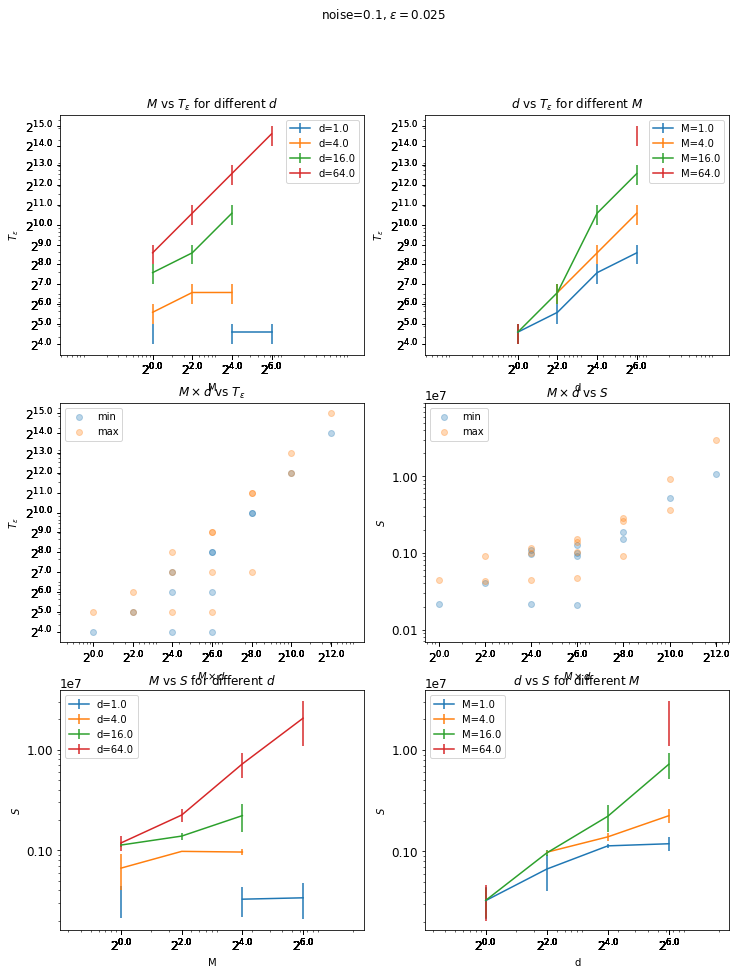

       d     M  noise  T_e_max  T_e_min         S_max      S_max_std  \
0    1.0   1.0    0.2     64.0     32.0  8.498766e+05   30928.519624   
1    1.0   4.0    0.2     64.0     32.0  9.306048e+05   35934.764217   
2    1.0  16.0    0.2     64.0     32.0  8.427156e+05   36499.110952   
3    1.0  64.0    0.2     64.0     32.0  8.358347e+05   39961.691180   
4    4.0   1.0    0.2    128.0     64.0  9.535046e+05   39152.909479   
5    4.0   4.0    0.2    256.0    128.0  8.937306e+05   35843.698195   
6    4.0  16.0    0.2    256.0      NaN  8.235302e+05   31259.904456   
7    4.0  64.0    0.2    256.0      NaN  8.839119e+05   40054.644987   
8   16.0   1.0    0.2    256.0    128.0  9.932962e+05   30502.397419   
9   16.0   4.0    0.2   1024.0    512.0  1.643309e+06   54055.322736   
10  16.0  16.0    0.2   4096.0   2048.0  3.262285e+06  115102.505378   
11  16.0  64.0    0.2   8192.0      NaN  4.525752e+06  239912.953900   
12  64.0   1.0    0.2   1024.0    512.0  1.606540e+06   41019.26

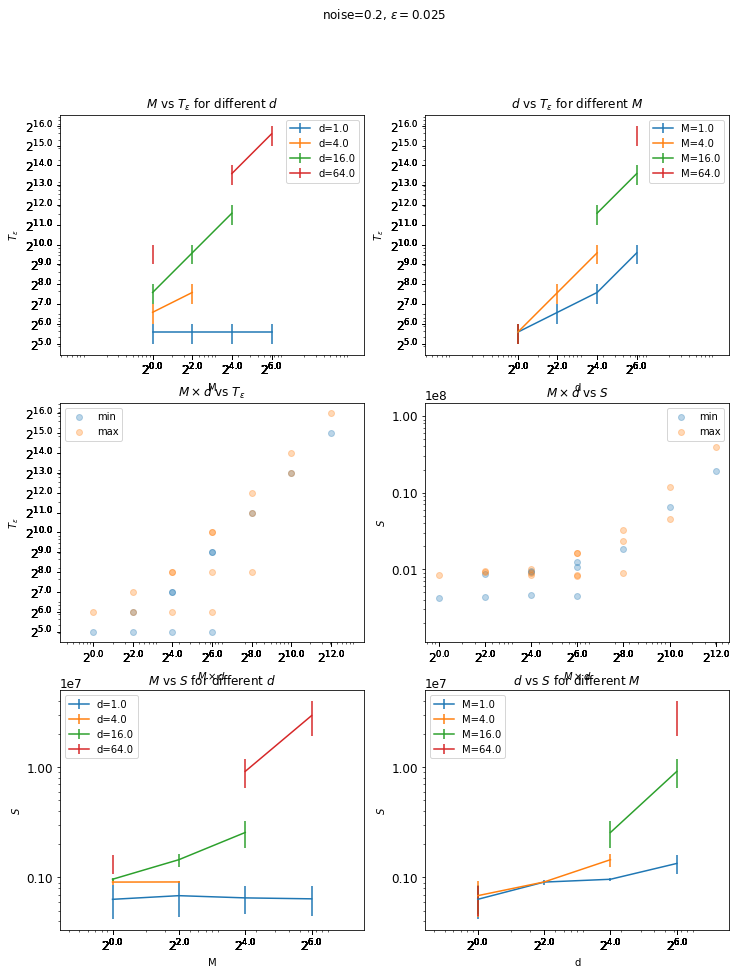

In [ ]:
epsilon = 0.025
grouped_noise = data_new.groupby(['noise'])
for noise in grouped_noise.groups.keys():
    print(analyze_data(grouped_noise.get_group(noise), epsilon))
    plt.gcf().suptitle(f'noise={noise}, $\epsilon={epsilon}$')
    plt.show()

       d     M  noise  T_e_max  T_e_min         S_max     S_max_std  \
0    1.0   1.0    0.1     64.0     32.0  9.538217e+05  3.330928e+04   
1    1.0   4.0    0.1     64.0     32.0  9.229188e+05  3.702969e+04   
2    1.0  64.0    0.1     64.0     32.0  9.517115e+05  3.924715e+04   
3    4.0   1.0    0.1    128.0     64.0  1.092418e+06  4.591968e+04   
4    4.0   4.0    0.1    256.0    128.0  1.103216e+06  4.655312e+04   
5    4.0  16.0    0.1    512.0    256.0  1.384464e+06  6.495820e+04   
6    4.0  64.0    0.1    512.0    256.0  1.282690e+06  6.327057e+04   
7   16.0   1.0    0.1    256.0    128.0  1.173480e+06  4.603154e+04   
8   16.0   4.0    0.1   1024.0    512.0  1.984184e+06  8.249644e+04   
9   16.0  16.0    0.1   4096.0   2048.0  4.816831e+06  8.747365e+04   
10  16.0  64.0    0.1  16384.0   8192.0  1.644675e+07  2.619438e+05   
11  64.0   1.0    0.1   1024.0    512.0  1.729706e+06  4.892210e+04   
12  64.0   4.0    0.1   2048.0   1024.0  2.594330e+06  7.711483e+04   
13  64

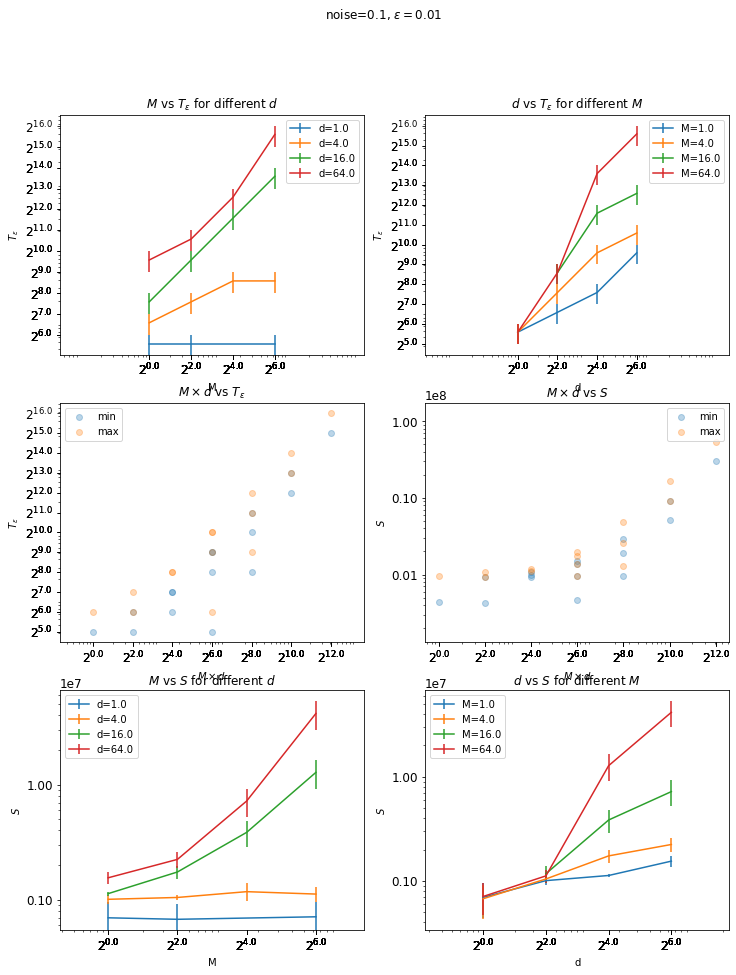

       d     M  noise   T_e_max   T_e_min         S_max     S_max_std  \
0    1.0   1.0    0.2     128.0      64.0  8.519690e+05  3.204234e+04   
1    1.0   4.0    0.2     128.0      64.0  8.271172e+05  3.435940e+04   
2    1.0  16.0    0.2     128.0      64.0  8.718232e+05  2.737521e+04   
3    1.0  64.0    0.2     256.0     128.0  8.502116e+05  3.831739e+04   
4    4.0   1.0    0.2     256.0     128.0  1.011702e+06  3.273957e+04   
5    4.0   4.0    0.2     512.0     256.0  1.084464e+06  5.394756e+04   
6    4.0  16.0    0.2    1024.0     512.0  1.461658e+06  6.981443e+04   
7    4.0  64.0    0.2    1024.0     512.0  1.488968e+06  6.945443e+04   
8   16.0   1.0    0.2     512.0     256.0  1.197695e+06  2.540428e+04   
9   16.0   4.0    0.2    2048.0    1024.0  2.110396e+06  7.806994e+04   
10  16.0  16.0    0.2    8192.0    4096.0  6.450315e+06  1.287830e+05   
11  16.0  64.0    0.2   65536.0   16384.0  3.707398e+07  6.702304e+05   
12  64.0   1.0    0.2    2048.0    1024.0  1.896305

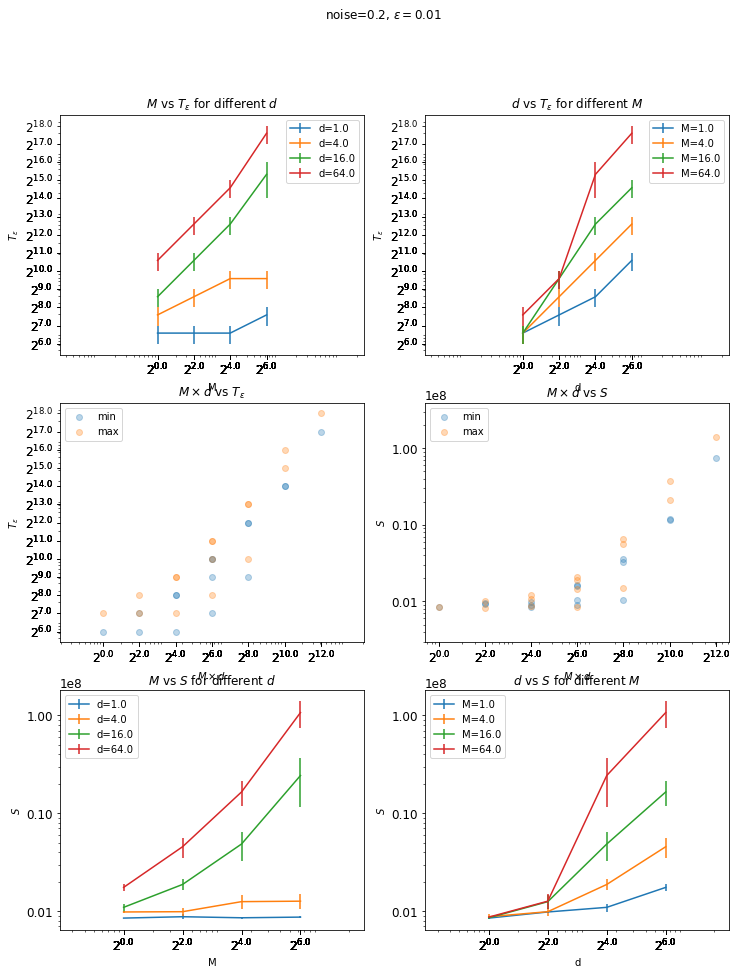

In [ ]:
epsilon = 0.01
grouped_noise = data_new.groupby(['noise'])
for noise in grouped_noise.groups.keys():
    print(analyze_data(grouped_noise.get_group(noise), epsilon))
    plt.gcf().suptitle(f'noise={noise}, $\epsilon={epsilon}$')
    plt.show()

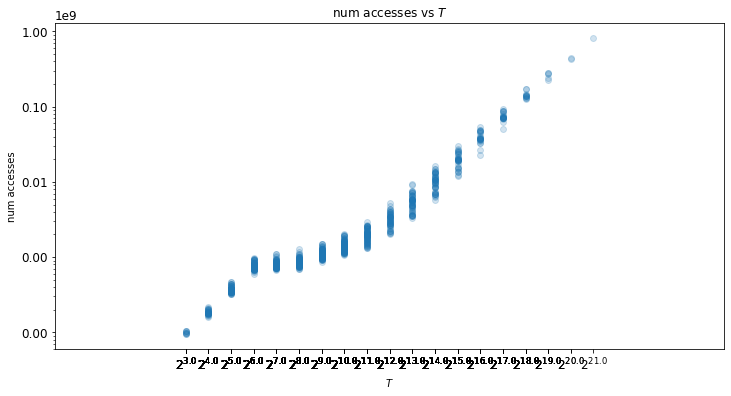

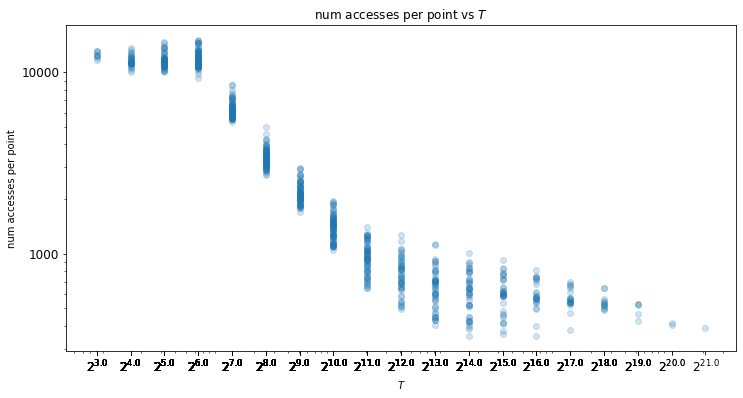

In [ ]:
def format_ax(ax):
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
_, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    data['T'],
    data['num_accesses_mean'],
    alpha=0.2,
)
format_ax(ax)
ax.set_xticks(data["T"].tolist())
ax.set_xticklabels(to_exp_str(data["T"].tolist()))
ax.axis('equal')
ax.set_xlabel('$T$')
ax.set_ylabel('num accesses')
ax.set_title(f"num accesses vs $T$")
plt.show()

_, ax = plt.subplots(figsize=(12, 6))
ax.scatter(
    data['T'],
    data['num_accesses_mean'] / data['T'],
    alpha=0.2,
)
format_ax(ax)
ax.set_xticks(data["T"].tolist())
ax.set_xticklabels(to_exp_str(data["T"].tolist()))
# ax.axis('equal')
ax.set_xlabel('$T$')
ax.set_ylabel('num accesses per point')
ax.set_title(f"num accesses per point vs $T$")
plt.show()

In [ ]:
raw = pd.read_excel(filename)
raw = raw.groupby([ 
    "d",
    "M",
    "noise",
    "T",
]).agg(
    max_model=pd.NamedAgg(column="model", aggfunc="max"),
    mean_model=pd.NamedAgg(column="model", aggfunc="mean"),
    median_model=pd.NamedAgg(column="model", aggfunc="median"),
).reset_index()
raw["model_limit"] = 16 + np.minimum( 
    2 * np.sqrt(raw["T"]),
    2 * np.sqrt(raw["M"] * raw["d"]) + 2 * np.maximum(
        raw["M"], 
        raw["d"],
    ),
)

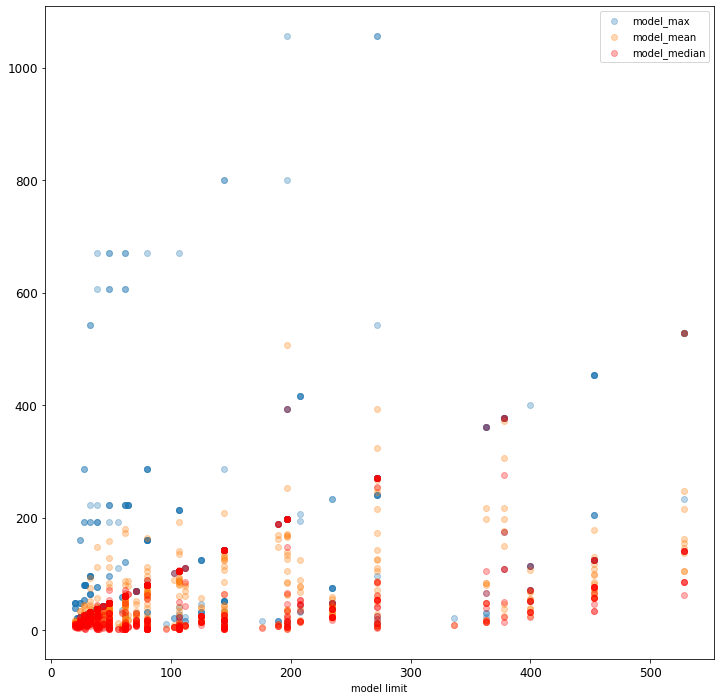

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
ax1.scatter(
    x = raw["model_limit"],
    y = raw["max_model"],
    alpha=0.3,
)
ax1.scatter(
    x = raw["model_limit"],
    y = raw["mean_model"],
    alpha=0.3,
)
ax1.scatter(
    x = raw["model_limit"],
    y = raw["median_model"],
    alpha=0.3,
    color="red",
)
ax1.legend(["model_max", "model_mean", "model_median"])
ax1.set_xlabel("model limit")
plt.show()

In [ ]:
raw[ 
    raw["median_model"] == raw["model_limit"]
]

,d,M,noise,T,max_model,mean_model,median_model,model_limit
79,2,2,0.1,32,24,17.250000,24.0,24.0
80,2,2,0.1,64,24,15.468750,24.0,24.0
99,2,8,0.1,64,32,23.406250,32.0,32.0
108,2,16,0.1,64,32,21.343750,32.0,32.0
110,2,16,0.1,256,48,37.750000,48.0,48.0
118,2,32,0.1,64,32,25.375000,32.0,32.0
123,2,32,0.2,256,48,31.562500,48.0,48.0
126,2,64,0.1,64,32,25.125000,32.0,32.0
139,2,128,0.2,256,48,35.687500,48.0,48.0
165,4,4,0.2,512,96,38.020833,32.0,32.0


In [ ]:
raw[ 
    (raw["M"] == 64)
    & (raw["d"] >= 32)
]

,d,M,noise,T,max_model,mean_model,median_model,model_limit
441,32,64,0.1,4096,143,86.468750,64.5,144.000000
442,32,64,0.1,8192,197,64.000000,34.0,197.019336
443,32,64,0.1,16384,76,31.281250,24.0,234.509668
444,32,64,0.1,32768,76,42.343750,38.0,234.509668
445,32,64,0.1,65536,49,44.875000,49.0,234.509668
446,32,64,0.2,8192,197,138.937500,197.0,197.019336
447,32,64,0.2,16384,234,56.312500,38.0,234.509668
448,32,64,0.2,32768,234,40.718750,38.0,234.509668
449,32,64,0.2,65536,49,38.656250,38.0,234.509668
450,32,64,0.2,131072,76,42.625000,38.0,234.509668
